# Ungraded Lab: Training a binary classifier with the IMDB Reviews Dataset

In this lab, you will be building a sentiment classification model to distinguish between positive and negative movie reviews. You will train it on the [IMDB Reviews](http://ai.stanford.edu/~amaas/data/sentiment/) dataset and visualize the word embeddings generated after training.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Download the Dataset

You will load the dataset via [Tensorflow Datasets](https://www.tensorflow.org/datasets), a collection of prepared datasets for machine learning. If you're running this notebook on your local machine, make sure to have the [`tensorflow-datasets`](https://pypi.org/project/tensorflow-datasets/) package installed before importing it. You can install it via `pip` as shown in the commented cell below.

In [1]:
try:
    import tensorflow_datasets as tfds
except ImportError:
    !pip install -q tensorflow-datasets
    import tensorflow_datasets as tfds

The [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method downloads the dataset into your working directory. You can set the `with_info` parameter to `True` if you want to see the description of the dataset. The `as_supervised` parameter, on the other hand, is set to load the data as `(input, label)` pairs.

To ensure smooth operation, the data was pre-downloaded and saved in the data folder. When you have the data already downloaded, you can read it by passing two additional arguments. With ` data_dir="./data/"`, you specify the folder where the data is located (if different than default) and by setting `download=False` you explicitly tell the method to read the data from the folder, rather than downloading it.

In [2]:
# Load the IMDB Reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True, data_dir="./data/", download=True)

In [3]:
# Print information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='data/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitIn

As you can see in the output above, there is a total of 100,000 examples in the dataset and it is split into `train`, `test` and `unsupervised` sets. For this lab, you will only use `train` and `test` sets because you will need labeled examples to train your model.

## Split the dataset

The `imdb` dataset that you downloaded earlier contains a dictionary pointing to [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects.

In [4]:
# Print the contents of the dataset
print(imdb)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'unsupervised': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [5]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
num_unsupervised_examples = info.splits['unsupervised'].num_examples

print(f'There are {num_train_examples} examples in the training set')
print(f'There are {num_test_examples} examples in the test set')
print(f'There are {num_unsupervised_examples} examples in the unsupervised set')

There are 25000 examples in the training set
There are 25000 examples in the test set
There are 50000 examples in the unsupervised set


You can preview the raw format of a few examples by using the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method and iterating over it as shown below:

In [6]:
# View 4 training examples
print('Four training examples...')
for example in imdb['train'].take(4):
  print(example)

# View 4 test examples
print('\nFour test examples...')
for example in imdb['test'].take(4):
  print(example)

# View 4 unsupervised examples
print('\nFour test examples...')
for example in imdb['unsupervised'].take(4):
  print(example)

Four training examples...
(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, bei

You can see that each example is a 2-element tuple of tensors containing the text first, then the label (shown in the `numpy()` property). The next cell below will take all the `train` and `test` sentences and labels into separate lists so you can preprocess the text and feed it to the model later.

In [7]:
# Get the train and test sets
train_dataset, test_dataset = imdb['train'], imdb['test']

## Generate Padded Sequences

Now you can do the text preprocessing steps you've learned last week. You will convert the strings to integer sequences, then pad them to a uniform length. The parameters are separated into its own code cell below so it will be easy for you to tweak it later if you want.

In [8]:
# Parameters

VOCAB_SIZE = 10000
MAX_LENGTH = 120
EMBEDDING_DIM = 16
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

An important thing to note here is you should generate the vocabulary based only on the training set. You should not include the test set because that is meant to represent data that the model hasn't seen before. With that, you can expect more unknown tokens (i.e. the value `1`) in the integer sequences of the test data. Also for clarity in demonstrating the transformations, you will first separate the reviews and labels. You will see other ways to implement the data pipeline in the next labs.

In [9]:
import tensorflow as tf

# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)
train_labels = train_dataset.map(lambda review, label: label)

# Get the string inputs and integer outputs of the test set
test_reviews = test_dataset.map(lambda review, label: review)
test_labels = test_dataset.map(lambda review, label: label)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

In [10]:
# Print reviews and labels of the training dataset
for review, label in train_dataset.take(10):
    print("Review:", review.numpy().decode('utf-8'))
    print("Label:", label.numpy())
    print("="*50)

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The 

You will define a padding function to generate the padded sequences. Note that the `pad_sequences()` function expects an iterable (e.g. list) while the input to this function is a `tf.data.Dataset`. Here's one way to do the conversion:
* Put all the elements in a single [ragged batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#ragged_batch) (i.e. batch with elements that have different lengths).
    * You will need to specify the batch size and it has to match the number of all elements in the dataset. From the output of the dataset info earlier, you know that this should be 25000.
    * Instead of specifying a specific number, you can also use the [cardinality()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cardinality) method. This computes the number of elements in a `tf.data.Dataset`.
* Use the [get_single_element()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#get_single_element) method on the single batch to output a Tensor.
* Convert back to a `tf.data.Dataset`. You'll see why this is needed in the next cell.

In [11]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=MAX_LENGTH,
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

This is the pipeline to convert the raw string inputs to padded integer sequences:
* Use the [map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method to pass each string to the `TextVectorization` layer defined earlier.
* Use the [apply()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#apply) method to use the padding function on the entire dataset.

The difference between `map()` and `apply()` is the mapping function in `map()` expects its input to be single elements (i.e. element-wise transformations), while the transformation function in `apply()` expects its input to be the entire dataset in the pipeline.

In [12]:
# Apply the layer to the train and test data
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)
test_sequences = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

You can take a few examples from the results and observe that the raw strings are now converted to padded integer sequences.

In [13]:
# View 2 training sequences
for example in train_sequences.take(2):
  print(example)
  print()

tf.Tensor(
[   0    0    0    0   11   14   34  412  384   18   90   28    1    8
   33 1322 3560   42  487    1  191   24   85  152   19   11  217  316
   28   65  240  214    8  489   54   65   85  112   96   22 5596   11
   93  642  743   11   18    7   34  394 9522  170 2464  408    2   88
 1216  137   66  144   51    2    1 7558   66  245   65 2870   16    1
 2860    1    1 1426 5050    3   40    1 1579   17 3560   14  158   19
    4 1216  891 8040    8    4   18   12   14 4059    5   99  146 1241
   10  237  704   12   48   24   93   39   11 7339  152   39 1322    1
   50  398   10   96 1155  851  141    9], shape=(120,), dtype=int32)

tf.Tensor(
[   0    0    0    0    0    0    0    0   10   26   75  617    6  776
 2355  299   95   19   11    7  604  662    6    4 2129    5  180  571
   63 1403  107 2410    3 3905   21    2    1    3  252   41 4781    4
  169  186   21   11 4259   10 1507 2355   80    2   20   14 1973    2
  114  943   14 1740 1300  594    3  356  180  446    6

You will now re-combine the sequences with the labels to prepare it for training.

In [14]:
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences,test_labels)

In [15]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0

Lastly, you will optimize and batch the datasets.

In [16]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Build and Compile the Model

With the data already preprocessed, you can proceed to building your sentiment classification model. The input will be an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. The main idea here is to represent each word in your vocabulary with vectors. These vectors have trainable weights so as your neural network learns, words that are most likely to appear in a positive tweet will converge towards similar weights. Similarly, words in negative tweets will be clustered more closely together. You can read more about word embeddings [here](https://www.tensorflow.org/text/guide/word_embeddings).

After the `Embedding` layer, you will flatten its output and feed it into a `Dense` layer. You will explore other architectures for these hidden layers in the next labs.

The output layer would be a single neuron with a sigmoid activation to distinguish between the 2 classes. As is typical with binary classifiers, you will use the `binary_crossentropy` as your loss function while training.

In [21]:
class SentimentModel:
    def __init__(self, vocab_size, embedding_dim, max_length):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(self.max_length,)),
            tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data
        )
        return history

    def summary(self):
        self.model.summary()

In [22]:
# Create an instance of the SentimentModel class
model = SentimentModel(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH)

# Compile the model
model.compile_model()

# Print the summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │          11,526 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Next, of course, is to train your model. With the current settings, you will get near perfect training accuracy after just 5 epochs but the validation accuracy will only be at around 80%. See if you can still improve this by adjusting some of the parameters earlier (e.g. the `VOCAB_SIZE`, number of `Dense` neurons, number of epochs, etc.).

In [23]:
NUM_EPOCHS = 5

# Train the model
history = model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6124 - loss: 0.6239 - val_accuracy: 0.8244 - val_loss: 0.3888
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8721 - loss: 0.3044 - val_accuracy: 0.8116 - val_loss: 0.4300
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9544 - loss: 0.1489 - val_accuracy: 0.8068 - val_loss: 0.5132
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9916 - loss: 0.0432 - val_accuracy: 0.8064 - val_loss: 0.5926
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9980 - loss: 0.0138 - val_accuracy: 0.8054 - val_loss: 0.6642


## Evaluating Accuracy and Loss for the Model

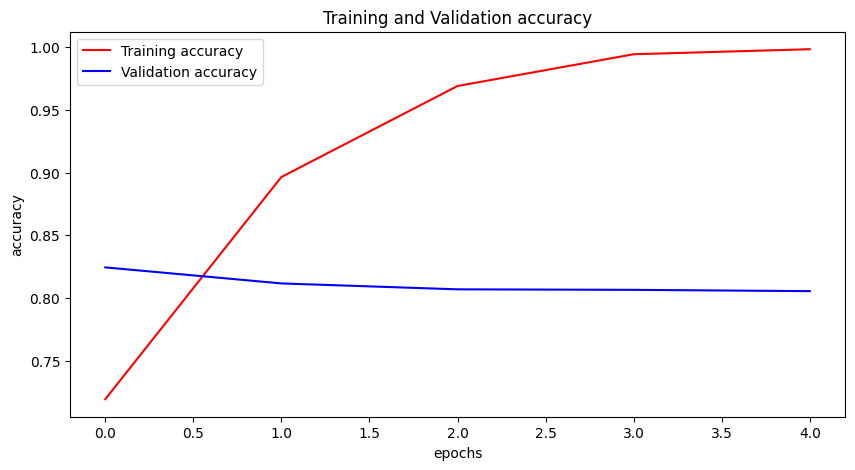

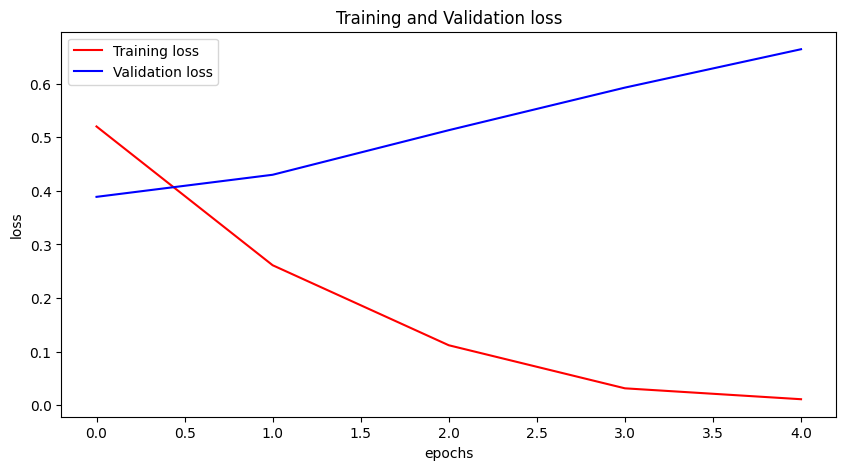

In [32]:
import matplotlib.pyplot as plt

def plot_metric(history, metric_name):
    '''Plots the training and validation loss and accuracy from a history object'''
    plt.figure(figsize=(10, 5))

    graph_1 = history.history[metric_name]
    graph_2 = history.history['val_' + metric_name]
    # range(len(graph_1)) == range(len(graph_2)) == each_epochs
    plt.plot(range(len(graph_1)), graph_1, 'r', label='Training' + ' ' +  metric_name)
    plt.plot(range(len(graph_2)), graph_2, 'b', label='Validation' + ' ' +  metric_name)
    plt.title('Training and Validation' + ' ' + metric_name)
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

## Save the history

In [25]:
import pickle
from google.colab import files

def download_history():
  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize Word Embeddings

After training, you can visualize the trained weights in the `Embedding` layer to see words that are clustered together. The [Tensorflow Embedding Projector](https://projector.tensorflow.org/) is able to reduce the 16-dimension vectors you defined earlier into fewer components so it can be plotted in the projector. First, you will need to get these weights and you can do that with the cell below:

In [30]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)


You will need to generate two files:

* `vecs.tsv` - contains the vector weights of each word in the vocabulary
* `meta.tsv` - contains the words in the vocabulary

You will get the word list from the `TextVectorization` layer you adapted earler, then start the loop to generate the files. You will loop `vocab_size-1` times, skipping the `0` key because it is just for the padding.

In [31]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Get the word list
vocabulary = vectorize_layer.get_vocabulary()

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, len(vocabulary)):

  # Get the word associated withAttributeError the current index
  word_name = vocabulary[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

You can find the files in your current working directory and download them. Now you can go to the [Tensorflow Embedding Projector](https://projector.tensorflow.org/) and load the two files you downloaded to see the visualization. You can search for words like `worst` and `fantastic` and see the other words closely located to these.

## Wrap Up

In this lab, you were able build a simple sentiment classification model and train it on preprocessed text data. In the next lessons, you will revisit the Sarcasm Dataset you used in Week 1 and build a model to train on it.